# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [1]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. The function should read both the weather and rainfall datafiles and create a merged feature vector array based on time-stamps.



In [2]:
def merge_weather_rain_data(data_path): # Select month for which data is collected
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weatherFrame = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,1,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weatherFrame.as_matrix()

    """ Read in the rain data"""
    rainFrame = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header =  None,
                             skiprows = 1,
                             index_col = None,
                             parse_dates = [0]
                            )
    rain_array = rainFrame.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_row.append(weather_array[valid_row][0].hour) # Add "time of day" information 
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

## Cleaning the data

The datafiles may contain missing entries, in such an event, it is needed to get rid of such datapoints. The function should take in the created feature vector array and delete rows if features are missing.


In [4]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        for elem in row[1:]: #Timestamp,Description cannot be "checked"
            if pd.isnull(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

def filter_by_month(data_array,month):
    """
    Filter weather data by month
    
    """
    rows_delete = []
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if row[0].month != month and row[0].month != (month+1):
            rows_delete.append(idx)
    filtered_array = np.delete(data_array,rows_delete,axis=0)
    return filtered_array

clean_data_array = clean_up(merged_array)
month_array = filter_by_month(clean_data_array,month = 7)
print(month_array.shape)

(8873, 9)


## Reading in the energy values

The aim of the assignment is to predict the solar energy produced based on the weather conditions. Thus, for each weather datapoint, the solar energy must be calclulated using the energy datafiles and matching the time-stamps. Define a function that first creates a single datastructure from all the different energy files. Then, design a function that can perform an energy look-up based on the time-stamp of the weather data. This fucntion should return the total solar energy produced between the previous timestamp and current timestamp.Using this look-up function, loop over all the time-stamps of the weather data and generate energy labels. It should be noted, that for certain time-stamps, the energy values might be missing, datapoints corresponding to such timestamps must be deleted from the data array. 

*Hint : Check the documentation for the python package pandas to design a fast lookup function*

In [5]:
def create_dataframe(energyDir):
    """ 
    Returns a dataframe that is formed by concatenating all the energy data files 
    """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
def energy_frame_month(energyDir,month):
    """
    Create an energy frame for only one month
    
    """
    energyDir = os.path.join(os.getcwd(),energyDir)
    if month < 10:
        monthDir = os.path.join(energyDir,'0{}'.format(month))
    else:
        monthDir = os.path.join(energyDir,'{}'.format(month))
        
    dirFiles = [os.path.join(monthDir, f) for f in os.listdir(monthDir) 
                    if os.path.isfile(os.path.join(monthDir,f))]
    fileList = []
    for f in dirFiles:
        fileList.append(f)
        fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame

    

frameList = []    
energyFrame = energy_frame_month('data/2017',month = 7)
energyFrame_next = energy_frame_month('data/2017',month = 8)
frameList.append(energyFrame)
frameList.append(energyFrame_next)
energyFrame_conc = pd.concat(frameList)
print(energyFrame_conc)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


               TimeStamp  Energy Consumed  Energy Produced  \
0    2017-07-01 00:00:01              860                0   
1    2017-07-01 00:00:11             1030                0   
2    2017-07-01 00:00:21             1020                0   
3    2017-07-01 00:00:31             1110                0   
4    2017-07-01 00:00:41             1010                0   
5    2017-07-01 00:00:51              880                0   
6    2017-07-01 00:01:01             1000                0   
7    2017-07-01 00:01:11              880                0   
8    2017-07-01 00:01:21             1010                0   
9    2017-07-01 00:01:31             1010                0   
10   2017-07-01 00:01:41              880                0   
11   2017-07-01 00:01:51             1020                0   
12   2017-07-01 00:02:01              880                0   
13   2017-07-01 00:02:11              990                0   
14   2017-07-01 00:02:21              870                0   
15   201

In [6]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(month_array,energyFrame_conc)
featureArray = np.delete(month_array,missing_labels,axis=0)
            

2017-07-01 00:10:00 55550 0
2017-07-01 00:20:00 51920 0
2017-07-01 00:30:00 76330 0
2017-07-01 00:40:00 47950 0
2017-07-01 00:50:00 46520 0
2017-07-01 01:00:00 46610 0
2017-07-01 01:10:00 40380 0
2017-07-01 01:20:00 45540 0
2017-07-01 01:30:00 34430 0
2017-07-01 01:40:00 39770 0
2017-07-01 01:50:00 43950 0
2017-07-01 02:00:00 27720 0
2017-07-01 02:10:00 25060 0
2017-07-01 02:20:00 18700 0
2017-07-01 02:30:00 14050 0
2017-07-01 02:40:00 20250 0
2017-07-01 02:50:00 52530 0
2017-07-01 03:00:00 24530 0
2017-07-01 03:10:00 19160 0
2017-07-01 03:20:00 16510 0
2017-07-01 03:30:00 14400 0
2017-07-01 03:40:00 12530 0
2017-07-01 03:50:00 10230 0
2017-07-01 04:00:00 8400 0
2017-07-01 04:10:00 12280 0
2017-07-01 04:20:00 8580 0
2017-07-01 04:30:00 9210 0
2017-07-01 04:40:00 18460 0
2017-07-01 04:50:00 19870 0
2017-07-01 05:00:00 20760 0
2017-07-01 05:10:00 21150 0
2017-07-01 05:20:00 14990 0
2017-07-01 05:30:00 14930 0
2017-07-01 05:40:00 12370 0
2017-07-01 05:50:00 8240 0
2017-07-01 06:00:00 1099

2017-07-03 00:50:00 32570 0
2017-07-03 01:00:00 40800 0
2017-07-03 01:10:00 21860 0
2017-07-03 01:20:00 18060 0
2017-07-03 01:30:00 17270 0
2017-07-03 01:40:00 15010 0
2017-07-03 01:50:00 16990 0
2017-07-03 02:00:00 10850 0
2017-07-03 02:10:00 9360 0
2017-07-03 02:20:00 12000 0
2017-07-03 02:30:00 11950 0
2017-07-03 02:40:00 10200 0
2017-07-03 02:50:00 18160 0
2017-07-03 03:00:00 24270 0
2017-07-03 03:10:00 20710 0
2017-07-03 03:20:00 21840 0
2017-07-03 03:30:00 19070 0
2017-07-03 03:40:00 11550 0
2017-07-03 03:50:00 10900 0
2017-07-03 04:00:00 29910 0
2017-07-03 04:10:00 9620 0
2017-07-03 04:20:00 10130 0
2017-07-03 04:30:00 19190 0
2017-07-03 04:40:00 15590 0
2017-07-03 04:50:00 15020 0
2017-07-03 05:00:00 15520 0
2017-07-03 05:10:00 10200 0
2017-07-03 05:20:00 9600 0
2017-07-03 05:30:00 12640 0
2017-07-03 05:40:00 10730 54
2017-07-03 05:50:00 8930 64
2017-07-03 06:00:00 16360 72
2017-07-03 06:10:00 19350 78
2017-07-03 06:20:00 20380 58
2017-07-03 06:30:00 19190 89
2017-07-03 06:40:0

2017-07-04 22:40:00 44350 0
2017-07-04 22:50:00 41050 0
2017-07-04 23:00:00 133820 0
2017-07-04 23:10:00 207970 0
2017-07-04 23:20:00 143610 0
2017-07-04 23:30:00 138560 0
2017-07-04 23:40:00 141690 0
2017-07-04 23:50:00 130960 0
2017-07-05 00:00:00 96840 0
2017-07-05 00:10:00 120320 0
2017-07-05 00:20:00 75780 0
2017-07-05 00:30:00 39850 0
2017-07-05 00:40:00 35750 0
2017-07-05 00:50:00 33640 0
2017-07-05 01:00:00 37440 0
2017-07-05 01:10:00 35550 0
2017-07-05 01:20:00 33160 0
2017-07-05 01:30:00 30230 0
2017-07-05 01:40:00 22120 0
2017-07-05 01:50:00 18970 0
2017-07-05 02:00:00 20480 0
2017-07-05 02:10:00 44600 0
2017-07-05 02:20:00 31150 0
2017-07-05 02:30:00 26050 0
2017-07-05 02:40:00 19830 0
2017-07-05 02:50:00 18230 0
2017-07-05 03:00:00 12290 0
2017-07-05 03:10:00 9210 0
2017-07-05 03:20:00 13910 0
2017-07-05 03:30:00 10330 0
2017-07-05 03:40:00 10850 0
2017-07-05 03:50:00 15930 0
2017-07-05 04:00:00 16250 0
2017-07-05 04:10:00 16140 0
2017-07-05 04:20:00 19130 0
2017-07-05 04:

2017-07-06 20:30:00 84750 119
2017-07-06 20:40:00 28030 111
2017-07-06 20:50:00 27720 80
2017-07-06 21:00:00 29970 95
2017-07-06 21:10:00 40650 82
2017-07-06 21:20:00 41650 63
2017-07-06 21:30:00 140280 0
2017-07-06 21:40:00 160100 0
2017-07-06 21:50:00 48660 0
2017-07-06 22:00:00 48190 0
2017-07-06 22:10:00 45400 0
2017-07-06 22:20:00 44670 0
2017-07-06 22:30:00 45960 0
2017-07-06 22:40:00 34090 0
2017-07-06 22:50:00 34120 0
2017-07-06 23:00:00 32650 0
2017-07-06 23:10:00 34960 0
2017-07-06 23:20:00 36410 0
2017-07-06 23:30:00 49900 0
2017-07-06 23:40:00 47480 0
2017-07-06 23:50:00 45220 0
2017-07-07 00:00:00 48160 0
2017-07-07 00:10:00 45210 0
2017-07-07 00:20:00 45190 0
2017-07-07 00:30:00 34270 0
2017-07-07 00:40:00 59590 0
2017-07-07 00:50:00 28190 0
2017-07-07 01:00:00 26780 0
2017-07-07 01:10:00 22870 0
2017-07-07 01:20:00 23750 0
2017-07-07 01:30:00 25240 0
2017-07-07 01:40:00 22820 0
2017-07-07 01:50:00 23600 0
2017-07-07 02:00:00 13170 0
2017-07-07 02:10:00 15190 0
2017-07-07

2017-07-09 00:50:00 45000 0
2017-07-09 01:00:00 37020 0
2017-07-09 01:10:00 34430 0
2017-07-09 01:20:00 24020 0
2017-07-09 01:30:00 19650 0
2017-07-09 01:40:00 22640 0
2017-07-09 01:50:00 19650 0
2017-07-09 02:00:00 20100 0
2017-07-09 02:10:00 25170 0
2017-07-09 02:20:00 19000 0
2017-07-09 02:30:00 17730 0
2017-07-09 02:40:00 12800 0
2017-07-09 02:50:00 10990 0
2017-07-09 03:00:00 14710 0
2017-07-09 03:10:00 11220 0
2017-07-09 03:20:00 13320 0
2017-07-09 03:30:00 12830 0
2017-07-09 03:40:00 19460 0
2017-07-09 03:50:00 34260 0
2017-07-09 04:00:00 16440 0
2017-07-09 04:10:00 14650 0
2017-07-09 04:20:00 21550 0
2017-07-09 04:30:00 20820 0
2017-07-09 04:40:00 18510 0
2017-07-09 04:50:00 18690 0
2017-07-09 05:00:00 16800 0
2017-07-09 05:10:00 19090 0
2017-07-09 05:20:00 18340 0
2017-07-09 05:30:00 16800 0
2017-07-09 05:40:00 20190 0
2017-07-09 05:50:00 16980 57
2017-07-09 06:00:00 16800 66
2017-07-09 06:10:00 18470 74
2017-07-09 06:20:00 14400 83
2017-07-09 06:30:00 18770 17
2017-07-09 06:4

2017-07-11 00:20:00 53710 0
2017-07-11 00:30:00 50700 0
2017-07-11 00:40:00 43100 0
2017-07-11 00:50:00 38330 0
2017-07-11 01:00:00 46180 0
2017-07-11 01:10:00 42800 0
2017-07-11 01:20:00 42530 0
2017-07-11 01:30:00 36240 0
2017-07-11 01:40:00 20220 0
2017-07-11 01:50:00 21230 0
2017-07-11 02:00:00 21520 0
2017-07-11 02:10:00 14590 0
2017-07-11 02:20:00 22880 0
2017-07-11 02:30:00 20270 0
2017-07-11 02:40:00 16050 0
2017-07-11 02:50:00 38220 0
2017-07-11 03:00:00 14500 0
2017-07-11 03:10:00 17970 0
2017-07-11 03:20:00 18450 0
2017-07-11 03:30:00 15860 0
2017-07-11 03:40:00 19920 0
2017-07-11 03:50:00 15520 0
2017-07-11 04:00:00 17000 0
2017-07-11 04:10:00 14210 0
2017-07-11 04:20:00 9720 0
2017-07-11 04:30:00 13600 0
2017-07-11 04:40:00 10640 0
2017-07-11 04:50:00 10810 0
2017-07-11 05:00:00 13010 0
2017-07-11 05:10:00 14840 0
2017-07-11 05:20:00 18110 0
2017-07-11 05:30:00 17190 0
2017-07-11 05:40:00 21000 0
2017-07-11 05:50:00 24330 0
2017-07-11 06:00:00 16990 58
2017-07-11 06:10:00 

2017-07-13 01:20:00 22670 0
2017-07-13 01:30:00 15750 0
2017-07-13 01:40:00 12320 0
2017-07-13 01:50:00 10280 0
2017-07-13 02:00:00 10890 0
2017-07-13 02:10:00 40640 0
2017-07-13 02:20:00 16190 0
2017-07-13 02:30:00 15820 0
2017-07-13 02:40:00 17380 0
2017-07-13 02:50:00 9720 0
2017-07-13 03:00:00 10180 0
2017-07-13 03:10:00 14530 0
2017-07-13 03:20:00 10620 0
2017-07-13 03:30:00 10350 0
2017-07-13 03:40:00 20200 0
2017-07-13 03:50:00 16190 0
2017-07-13 04:00:00 19400 0
2017-07-13 04:10:00 22490 0
2017-07-13 04:20:00 16330 0
2017-07-13 04:30:00 15290 0
2017-07-13 04:40:00 18230 0
2017-07-13 04:50:00 13930 0
2017-07-13 05:00:00 10370 0
2017-07-13 05:10:00 19630 0
2017-07-13 05:20:00 17010 0
2017-07-13 05:30:00 15380 0
2017-07-13 05:40:00 14050 0
2017-07-13 05:50:00 11650 57
2017-07-13 06:00:00 31124 65
2017-07-13 06:10:00 10920 72
2017-07-13 06:20:00 10160 137
2017-07-13 06:30:00 9360 124
2017-07-13 06:40:00 14700 158
2017-07-13 06:50:00 18590 63
2017-07-13 07:00:00 14860 55
2017-07-13 

2017-07-15 01:20:00 7860 0
2017-07-15 01:30:00 7800 0
2017-07-15 01:40:00 11110 0
2017-07-15 01:50:00 11190 0
2017-07-15 02:00:00 18360 0
2017-07-15 02:10:00 46690 0
2017-07-15 02:20:00 15720 0
2017-07-15 02:30:00 12490 0
2017-07-15 02:40:00 15000 0
2017-07-15 02:50:00 9980 0
2017-07-15 03:00:00 7800 0
2017-07-15 03:10:00 10330 0
2017-07-15 03:20:00 15580 0
2017-07-15 03:30:00 13380 0
2017-07-15 03:40:00 14200 0
2017-07-15 03:50:00 11040 0
2017-07-15 04:00:00 7800 0
2017-07-15 04:10:00 7800 0
2017-07-15 04:20:00 12070 0
2017-07-15 04:30:00 8520 0
2017-07-15 04:40:00 8930 0
2017-07-15 04:50:00 16620 0
2017-07-15 05:00:00 14730 0
2017-07-15 05:10:00 10770 0
2017-07-15 05:20:00 9790 0
2017-07-15 05:30:00 12030 0
2017-07-15 05:40:00 12660 68
2017-07-15 05:50:00 13500 58
2017-07-15 06:00:00 39920 72
2017-07-15 06:10:00 14460 100
2017-07-15 06:20:00 12970 50
2017-07-15 06:30:00 17110 53
2017-07-15 06:40:00 8610 66
2017-07-15 06:50:00 7850 58
2017-07-15 07:00:00 10480 57
2017-07-15 07:10:00 8

2017-07-17 02:40:00 15040 0
2017-07-17 02:50:00 12620 0
2017-07-17 03:00:00 14400 0
2017-07-17 03:10:00 41930 0
2017-07-17 03:20:00 13250 0
2017-07-17 03:30:00 14500 0
2017-07-17 03:40:00 10260 0
2017-07-17 03:50:00 7800 0
2017-07-17 04:00:00 8750 0
2017-07-17 04:10:00 10860 0
2017-07-17 04:20:00 7800 0
2017-07-17 04:30:00 12320 0
2017-07-17 04:40:00 17400 0
2017-07-17 04:50:00 13250 0
2017-07-17 05:00:00 9400 0
2017-07-17 05:10:00 13370 0
2017-07-17 05:20:00 8300 0
2017-07-17 05:30:00 7700 0
2017-07-17 05:40:00 15790 0
2017-07-17 05:50:00 15700 0
2017-07-17 06:00:00 18920 0
2017-07-17 06:10:00 20330 0
2017-07-17 06:20:00 16910 0
2017-07-17 06:30:00 7750 0
2017-07-17 06:40:00 31360 0
2017-07-17 06:50:00 10650 60
2017-07-17 07:00:00 5560 81
2017-07-17 07:10:00 7180 50
2017-07-17 07:20:00 14760 21
2017-07-17 07:30:00 14550 79
2017-07-17 07:40:00 12840 8
2017-07-17 07:50:00 11100 76
2017-07-17 08:00:00 9850 81
2017-07-17 08:10:00 -5630 322
2017-07-17 08:20:00 -7560 287
2017-07-17 08:30:00

Missing label for row 2557
Missing label for row 2558
Missing label for row 2559
Missing label for row 2560
Missing label for row 2561
Missing label for row 2562
Missing label for row 2563
Missing label for row 2564
Missing label for row 2565
Missing label for row 2566
Missing label for row 2567
Missing label for row 2568
Missing label for row 2569
Missing label for row 2570
Missing label for row 2571
Missing label for row 2572
Missing label for row 2573
Missing label for row 2574
Missing label for row 2575
Missing label for row 2576
Missing label for row 2577
Missing label for row 2578
Missing label for row 2579
Missing label for row 2580
Missing label for row 2581
Missing label for row 2582
Missing label for row 2583
Missing label for row 2584
Missing label for row 2585
Missing label for row 2586
Missing label for row 2587
Missing label for row 2588
Missing label for row 2589
Missing label for row 2590
Missing label for row 2591
Missing label for row 2592
Missing label for row 2593
M

2017-07-21 04:30:00 13460 0
2017-07-21 04:40:00 12110 0
2017-07-21 04:50:00 16280 0
2017-07-21 05:00:00 13020 0
2017-07-21 05:10:00 13300 0
2017-07-21 05:20:00 22790 0
2017-07-21 05:30:00 24250 0
2017-07-21 05:40:00 24800 0
2017-07-21 05:50:00 24730 0
2017-07-21 06:00:00 41150 54
2017-07-21 06:10:00 22190 62
2017-07-21 06:20:00 13880 91
2017-07-21 06:30:00 10460 73
2017-07-21 06:40:00 14730 40
2017-07-21 06:50:00 13830 56
2017-07-21 07:00:00 11470 52
2017-07-21 07:10:00 -2730 306
2017-07-21 07:20:00 -8420 531
2017-07-21 07:30:00 -13960 529
2017-07-21 07:40:00 -13430 495
2017-07-21 07:50:00 -24120 835
2017-07-21 08:00:00 13190 583
2017-07-21 08:10:00 -14010 790
2017-07-21 08:20:00 -21550 786
2017-07-21 08:30:00 -27860 842
2017-07-21 08:40:00 -34410 1027
2017-07-21 08:50:00 -27470 1043
2017-07-21 09:00:00 -51920 1105
2017-07-21 09:10:00 -61050 1428
2017-07-21 09:20:00 -51290 1379
2017-07-21 09:30:00 -67180 1471
2017-07-21 09:40:00 -69430 1632
2017-07-21 09:50:00 -83040 1741
2017-07-21 10

2017-07-23 03:30:00 16300 0
2017-07-23 03:40:00 14240 0
2017-07-23 03:50:00 14270 0
2017-07-23 04:00:00 16340 0
2017-07-23 04:10:00 13200 0
2017-07-23 04:20:00 22410 0
2017-07-23 04:30:00 20580 0
2017-07-23 04:40:00 19010 0
2017-07-23 04:50:00 22360 0
2017-07-23 05:00:00 18600 0
2017-07-23 05:10:00 18780 0
2017-07-23 05:20:00 15010 0
2017-07-23 05:30:00 13210 0
2017-07-23 05:40:00 20440 0
2017-07-23 05:50:00 18980 0
2017-07-23 06:00:00 20130 0
2017-07-23 06:10:00 21100 54
2017-07-23 06:20:00 23260 83
2017-07-23 06:30:00 44570 92
2017-07-23 06:40:00 18290 68
2017-07-23 06:50:00 17990 70
2017-07-23 07:00:00 20350 77
2017-07-23 07:10:00 9900 112
2017-07-23 07:20:00 3330 157
2017-07-23 07:30:00 -11020 566
2017-07-23 07:40:00 -11580 674
2017-07-23 07:50:00 -23980 796
2017-07-23 08:00:00 690 880
2017-07-23 08:10:00 4400 850
2017-07-23 08:20:00 -26130 976
2017-07-23 08:30:00 -27070 745
2017-07-23 08:40:00 -28090 1015
2017-07-23 08:50:00 -27510 893
2017-07-23 09:00:00 -40290 883
2017-07-23 09:

2017-07-25 04:10:00 21790 0
2017-07-25 04:20:00 16640 0
2017-07-25 04:30:00 12740 0
2017-07-25 04:40:00 16370 0
2017-07-25 04:50:00 12220 0
2017-07-25 05:00:00 7800 0
2017-07-25 05:10:00 10330 0
2017-07-25 05:20:00 14480 0
2017-07-25 05:30:00 13520 0
2017-07-25 05:40:00 14830 0
2017-07-25 05:50:00 14160 0
2017-07-25 06:00:00 7800 0
2017-07-25 06:10:00 8930 0
2017-07-25 06:20:00 10980 0
2017-07-25 06:30:00 26386 58
2017-07-25 06:40:00 7050 66
2017-07-25 06:50:00 13390 73
2017-07-25 07:00:00 11870 95
2017-07-25 07:10:00 14540 66
2017-07-25 07:20:00 21110 58
2017-07-25 07:30:00 11100 51
2017-07-25 07:40:00 -6700 364
2017-07-25 07:50:00 -12630 510
2017-07-25 08:00:00 -16340 510
2017-07-25 08:10:00 -22690 492
2017-07-25 08:20:00 -17210 543
2017-07-25 08:30:00 -6980 346
2017-07-25 08:40:00 -17490 649
2017-07-25 08:50:00 -25710 671
2017-07-25 09:00:00 -46570 609
2017-07-25 09:10:00 -65300 1222
2017-07-25 09:20:00 -63430 679
2017-07-25 09:30:00 -57030 1683
2017-07-25 09:40:00 -37990 694
2017-0

2017-07-27 02:00:00 19100 0
2017-07-27 02:10:00 42870 0
2017-07-27 02:20:00 21860 0
2017-07-27 02:30:00 21010 0
2017-07-27 02:40:00 16270 0
2017-07-27 02:50:00 10940 0
2017-07-27 03:00:00 11380 0
2017-07-27 03:10:00 10560 0
2017-07-27 03:20:00 8980 0
2017-07-27 03:30:00 11130 0
2017-07-27 03:40:00 10290 0
2017-07-27 03:50:00 15100 0
2017-07-27 04:00:00 18330 0
2017-07-27 04:10:00 15340 0
2017-07-27 04:20:00 14400 0
2017-07-27 04:30:00 14720 0
2017-07-27 04:40:00 15390 0
2017-07-27 04:50:00 14510 0
2017-07-27 05:00:00 17500 0
2017-07-27 05:10:00 14760 0
2017-07-27 05:20:00 30960 0
2017-07-27 05:30:00 18760 0
2017-07-27 05:40:00 15610 0
2017-07-27 05:50:00 14400 0
2017-07-27 06:00:00 17540 0
2017-07-27 06:10:00 9790 0
2017-07-27 06:20:00 8040 86
2017-07-27 06:30:00 8710 120
2017-07-27 06:40:00 8890 59
2017-07-27 06:50:00 8560 68
2017-07-27 07:00:00 14670 47
2017-07-27 07:10:00 14660 67
2017-07-27 07:20:00 14590 74
2017-07-27 07:30:00 17850 73
2017-07-27 07:40:00 14850 65
2017-07-27 07:50

2017-07-29 02:10:00 18240 0
2017-07-29 02:20:00 20190 0
2017-07-29 02:30:00 22500 0
2017-07-29 02:40:00 24940 0
2017-07-29 02:50:00 18450 0
2017-07-29 03:00:00 15450 0
2017-07-29 03:10:00 13390 0
2017-07-29 03:20:00 10410 0
2017-07-29 03:30:00 9040 0
2017-07-29 03:40:00 13040 0
2017-07-29 03:50:00 16970 0
2017-07-29 04:00:00 35220 0
2017-07-29 04:10:00 16960 0
2017-07-29 04:20:00 12780 0
2017-07-29 04:30:00 9000 0
2017-07-29 04:40:00 11190 0
2017-07-29 04:50:00 11160 0
2017-07-29 05:00:00 9000 0
2017-07-29 05:10:00 10470 0
2017-07-29 05:20:00 18920 0
2017-07-29 05:30:00 20340 0
2017-07-29 05:40:00 20690 0
2017-07-29 05:50:00 20380 0
2017-07-29 06:00:00 13800 0
2017-07-29 06:10:00 11870 0
2017-07-29 06:20:00 12810 65
2017-07-29 06:30:00 8240 68
2017-07-29 06:40:00 9710 75
2017-07-29 06:50:00 15260 72
2017-07-29 07:00:00 12070 133
2017-07-29 07:10:00 12120 90
2017-07-29 07:20:00 6310 514
2017-07-29 07:30:00 -2800 667
2017-07-29 07:40:00 -7350 263
2017-07-29 07:50:00 -4040 372
2017-07-29 

2017-07-31 00:30:00 26980 0
2017-07-31 00:40:00 25520 0
2017-07-31 00:50:00 26180 0
2017-07-31 01:00:00 28540 0
2017-07-31 01:10:00 29980 0
2017-07-31 01:20:00 29440 0
2017-07-31 01:30:00 27520 0
2017-07-31 01:40:00 26270 0
2017-07-31 01:50:00 19300 0
2017-07-31 02:00:00 16830 0
2017-07-31 02:10:00 20030 0
2017-07-31 02:20:00 17030 0
2017-07-31 02:30:00 14080 0
2017-07-31 02:40:00 20100 0
2017-07-31 02:50:00 38920 0
2017-07-31 03:00:00 22600 0
2017-07-31 03:10:00 24840 0
2017-07-31 03:20:00 15250 0
2017-07-31 03:30:00 15530 0
2017-07-31 03:40:00 14590 0
2017-07-31 03:50:00 9250 0
2017-07-31 04:00:00 11030 0
2017-07-31 04:10:00 14110 0
2017-07-31 04:20:00 15260 0
2017-07-31 04:30:00 17350 0
2017-07-31 04:40:00 16140 0
2017-07-31 04:50:00 13680 0
2017-07-31 05:00:00 11370 0
2017-07-31 05:10:00 10680 0
2017-07-31 05:20:00 9000 0
2017-07-31 05:30:00 11850 0
2017-07-31 05:40:00 10400 0
2017-07-31 05:50:00 13210 0
2017-07-31 06:00:00 22090 0
2017-07-31 06:10:00 21490 0
2017-07-31 06:20:00 38

2017-08-01 23:30:00 25150 687
2017-08-01 23:40:00 26030 687
2017-08-01 23:50:00 25180 0
2017-08-02 00:00:00 28760 0
2017-08-02 00:10:00 158500 0
2017-08-02 00:20:00 99290 0
2017-08-02 00:30:00 104200 0
2017-08-02 00:40:00 87680 0
2017-08-02 00:50:00 50700 0
2017-08-02 01:00:00 20540 0
2017-08-02 01:10:00 19710 0
2017-08-02 01:20:00 20080 0
2017-08-02 01:30:00 15340 0
2017-08-02 01:40:00 16280 0
2017-08-02 01:50:00 22370 0
2017-08-02 02:00:00 17120 0
2017-08-02 02:10:00 12840 0
2017-08-02 02:20:00 28362 0
2017-08-02 02:30:00 13820 0
2017-08-02 02:40:00 15760 0
2017-08-02 02:50:00 14930 0
2017-08-02 03:00:00 12870 0
2017-08-02 03:10:00 18130 0
2017-08-02 03:20:00 15190 0
2017-08-02 03:30:00 12610 0
2017-08-02 03:40:00 14590 0
2017-08-02 03:50:00 13670 0
2017-08-02 04:00:00 8200 0
2017-08-02 04:10:00 16480 0
2017-08-02 04:20:00 15190 0
2017-08-02 04:30:00 13190 0
2017-08-02 04:40:00 15190 0
2017-08-02 04:50:00 11220 0
2017-08-02 05:00:00 7800 0
2017-08-02 05:10:00 10890 0
2017-08-02 05:20

2017-08-04 02:00:00 16660 0
2017-08-04 02:10:00 12840 0
2017-08-04 02:20:00 10800 0
2017-08-04 02:30:00 13080 0
2017-08-04 02:40:00 12910 0
2017-08-04 02:50:00 10820 0
2017-08-04 03:00:00 19620 0
2017-08-04 03:10:00 17700 0
2017-08-04 03:20:00 14860 0
2017-08-04 03:30:00 16610 0
2017-08-04 03:40:00 14090 0
2017-08-04 03:50:00 14920 0
2017-08-04 04:00:00 16750 0
2017-08-04 04:10:00 34090 0
2017-08-04 04:20:00 13800 0
2017-08-04 04:30:00 15220 0
2017-08-04 04:40:00 17810 0
2017-08-04 04:50:00 14800 0
2017-08-04 05:00:00 16360 0
2017-08-04 05:10:00 16910 0
2017-08-04 05:20:00 9550 0
2017-08-04 05:30:00 10830 0
2017-08-04 05:40:00 12050 0
2017-08-04 05:50:00 9420 0
2017-08-04 06:00:00 10500 0
2017-08-04 06:10:00 14880 0
2017-08-04 06:20:00 15460 0
2017-08-04 06:30:00 15460 0
2017-08-04 06:40:00 16750 0
2017-08-04 06:50:00 13940 0
2017-08-04 07:00:00 12150 0
2017-08-04 07:10:00 17660 0
2017-08-04 07:20:00 13950 0
2017-08-04 07:30:00 31510 0
2017-08-04 07:40:00 12960 0
2017-08-04 07:50:00 16

2017-08-06 03:20:00 14900 0
2017-08-06 03:30:00 24170 0
2017-08-06 03:40:00 20670 0
2017-08-06 03:50:00 14800 0
2017-08-06 04:00:00 13720 0
2017-08-06 04:10:00 11600 0
2017-08-06 04:20:00 9020 0
2017-08-06 04:30:00 10630 0
2017-08-06 04:40:00 12800 0
2017-08-06 04:50:00 27790 0
2017-08-06 05:00:00 15590 0
2017-08-06 05:10:00 18120 0
2017-08-06 05:20:00 15660 0
2017-08-06 05:30:00 10270 0
2017-08-06 05:40:00 10900 0
2017-08-06 05:50:00 11580 0
2017-08-06 06:00:00 10110 0
2017-08-06 06:10:00 15250 0
2017-08-06 06:20:00 19650 0
2017-08-06 06:30:00 20120 0
2017-08-06 06:40:00 18090 0
2017-08-06 06:50:00 15710 0
2017-08-06 07:00:00 11680 0
2017-08-06 07:10:00 10510 0
2017-08-06 07:20:00 8880 0
2017-08-06 07:30:00 -7320 0
2017-08-06 07:40:00 -9260 0
2017-08-06 07:50:00 -8260 0
2017-08-06 08:00:00 13550 0
2017-08-06 08:10:00 -7530 0
2017-08-06 08:20:00 -14630 0
2017-08-06 08:30:00 -14360 0
2017-08-06 08:40:00 -5110 0
2017-08-06 08:50:00 -8570 0
2017-08-06 09:00:00 -20840 0
2017-08-06 09:10:00

Missing label for row 5459
Missing label for row 5460
Missing label for row 5461
Missing label for row 5462
Missing label for row 5463
Missing label for row 5464
Missing label for row 5465
Missing label for row 5466
Missing label for row 5467
Missing label for row 5468
Missing label for row 5469
Missing label for row 5470
Missing label for row 5471
Missing label for row 5472
Missing label for row 5473
Missing label for row 5474
Missing label for row 5475
Missing label for row 5476
Missing label for row 5477
Missing label for row 5478
Missing label for row 5479
Missing label for row 5480
Missing label for row 5481
Missing label for row 5482
Missing label for row 5483
Missing label for row 5484
Missing label for row 5485
Missing label for row 5486
Missing label for row 5487
Missing label for row 5488
Missing label for row 5489
Missing label for row 5490
Missing label for row 5491
Missing label for row 5492
Missing label for row 5493
Missing label for row 5494
Missing label for row 5495
M

2017-08-10 10:50:00 2880 0
2017-08-10 11:00:00 -1180 0
2017-08-10 11:10:00 -4160 0
2017-08-10 11:20:00 -5440 0
2017-08-10 11:30:00 14050 0
2017-08-10 11:40:00 -3610 0
2017-08-10 11:50:00 89370 0
2017-08-10 12:00:00 102000 0
2017-08-10 12:10:00 34700 0
2017-08-10 12:20:00 10570 0
2017-08-10 12:30:00 6940 0
2017-08-10 12:40:00 4870 0
2017-08-10 12:50:00 -6030 0
2017-08-10 13:00:00 -14520 0
2017-08-10 13:10:00 7570 0
2017-08-10 13:20:00 8040 0
2017-08-10 13:30:00 -1730 0
2017-08-10 13:40:00 12790 0
2017-08-10 13:50:00 9830 0
2017-08-10 14:00:00 39628 0
2017-08-10 14:10:00 51960 0
2017-08-10 14:20:00 33290 0
2017-08-10 14:30:00 880 0
2017-08-10 14:40:00 8770 0
2017-08-10 14:50:00 10840 0
2017-08-10 15:00:00 18230 0
2017-08-10 15:10:00 21640 0
2017-08-10 15:20:00 15630 0
2017-08-10 15:30:00 14090 0
2017-08-10 15:40:00 12250 0
2017-08-10 15:50:00 820 0
2017-08-10 16:00:00 3280 0
2017-08-10 16:10:00 3580 0
2017-08-10 16:20:00 3020 0
2017-08-10 16:30:00 4210 0
2017-08-10 16:40:00 450 0
2017-08

2017-08-12 13:30:00 31658 0
2017-08-12 13:40:00 -27020 0
2017-08-12 13:50:00 -62510 0
2017-08-12 14:00:00 -23870 0
2017-08-12 14:10:00 2100 0
2017-08-12 14:20:00 -4380 0
2017-08-12 14:30:00 -26530 0
2017-08-12 14:40:00 4690 0
2017-08-12 14:50:00 4730 0
2017-08-12 15:00:00 -8040 0
2017-08-12 15:10:00 9290 0
2017-08-12 15:20:00 1360 0
2017-08-12 15:30:00 -44270 0
2017-08-12 15:40:00 9800 0
2017-08-12 15:50:00 161710 0
2017-08-12 16:00:00 65130 0
2017-08-12 16:10:00 43090 0
2017-08-12 16:20:00 45390 0
2017-08-12 16:30:00 5400 0
2017-08-12 16:40:00 -1200 0
2017-08-12 16:50:00 -38680 0
2017-08-12 17:00:00 -35700 0
2017-08-12 17:10:00 -31180 0
2017-08-12 17:20:00 2600 0
2017-08-12 17:30:00 19120 0
2017-08-12 17:40:00 13520 0
2017-08-12 17:50:00 24130 0
2017-08-12 18:00:00 6430 0
2017-08-12 18:10:00 33707 0
2017-08-12 18:20:00 21880 0
2017-08-12 18:30:00 27680 0
2017-08-12 18:40:00 151240 0
2017-08-12 18:50:00 121606 0
2017-08-12 19:00:00 39170 0
2017-08-12 19:10:00 24020 0
2017-08-12 19:20:0

2017-08-14 16:10:00 -29160 0
2017-08-14 16:20:00 -37270 0
2017-08-14 16:30:00 -68130 0
2017-08-14 16:40:00 -40120 0
2017-08-14 16:50:00 -12510 0
2017-08-14 17:00:00 -7770 0
2017-08-14 17:10:00 -32480 0
2017-08-14 17:20:00 -16820 0
2017-08-14 17:30:00 -17320 0
2017-08-14 17:40:00 550 0
2017-08-14 17:50:00 -3750 0
2017-08-14 18:00:00 1880 0
2017-08-14 18:10:00 -5130 0
2017-08-14 18:20:00 790 0
2017-08-14 18:30:00 7840 0
2017-08-14 18:40:00 11410 0
2017-08-14 18:50:00 12800 0
2017-08-14 19:00:00 41170 0
2017-08-14 19:10:00 22930 0
2017-08-14 19:20:00 21540 0
2017-08-14 19:30:00 26430 0
2017-08-14 19:40:00 145030 0
2017-08-14 19:50:00 118650 0
2017-08-14 20:00:00 66000 0
2017-08-14 20:10:00 19790 0
2017-08-14 20:20:00 20410 0
2017-08-14 20:30:00 26960 0
2017-08-14 20:40:00 27680 0
2017-08-14 20:50:00 24850 0
2017-08-14 21:00:00 58990 0
2017-08-14 21:10:00 42950 0
2017-08-14 21:20:00 43460 0
2017-08-14 21:30:00 39640 0
2017-08-14 21:40:00 36830 0
2017-08-14 21:50:00 38030 0
2017-08-14 22:00

Missing label for row 6695
Missing label for row 6696
Missing label for row 6697
Missing label for row 6698
Missing label for row 6699
Missing label for row 6700
Missing label for row 6701
Missing label for row 6702
Missing label for row 6703
Missing label for row 6704
Missing label for row 6705
Missing label for row 6706
Missing label for row 6707
Missing label for row 6708
Missing label for row 6709
Missing label for row 6710
Missing label for row 6711
Missing label for row 6712
Missing label for row 6713
Missing label for row 6714
Missing label for row 6715
Missing label for row 6716
Missing label for row 6717
Missing label for row 6718
Missing label for row 6719
Missing label for row 6720
Missing label for row 6721
Missing label for row 6722
Missing label for row 6723
Missing label for row 6724
Missing label for row 6725
Missing label for row 6726
Missing label for row 6727
Missing label for row 6728
Missing label for row 6729
Missing label for row 6730
Missing label for row 6731
M

2017-08-19 01:00:00 21690 0
2017-08-19 01:10:00 44430 0
2017-08-19 01:20:00 17530 0
2017-08-19 01:30:00 23960 0
2017-08-19 01:40:00 26700 0
2017-08-19 01:50:00 23110 0
2017-08-19 02:00:00 25810 0
2017-08-19 02:10:00 21270 0
2017-08-19 02:20:00 15840 0
2017-08-19 02:30:00 13620 0
2017-08-19 02:40:00 9620 0
2017-08-19 02:50:00 12730 0
2017-08-19 03:00:00 11620 0
2017-08-19 03:10:00 9600 0
2017-08-19 03:20:00 14580 0
2017-08-19 03:30:00 17200 0
2017-08-19 03:40:00 15790 0
2017-08-19 03:50:00 18690 0
2017-08-19 04:00:00 14970 0
2017-08-19 04:10:00 11110 0
2017-08-19 04:20:00 12100 0
2017-08-19 04:30:00 11970 0
2017-08-19 04:40:00 17940 0
2017-08-19 04:50:00 38980 0
2017-08-19 05:00:00 14340 0
2017-08-19 05:10:00 20590 0
2017-08-19 05:20:00 17910 0
2017-08-19 05:30:00 16030 0
2017-08-19 05:40:00 18300 0
2017-08-19 05:50:00 11830 0
2017-08-19 06:00:00 11300 0
2017-08-19 06:10:00 12530 0
2017-08-19 06:20:00 9230 0
2017-08-19 06:30:00 11460 0
2017-08-19 06:40:00 12180 0
2017-08-19 06:50:00 108

2017-08-21 01:10:00 22370 0
2017-08-21 01:20:00 23530 0
2017-08-21 01:30:00 23660 0
2017-08-21 01:40:00 27740 0
2017-08-21 01:50:00 24020 0
2017-08-21 02:00:00 20230 0
2017-08-21 02:10:00 16900 0
2017-08-21 02:20:00 34810 0
2017-08-21 02:30:00 17470 0
2017-08-21 02:40:00 10520 0
2017-08-21 02:50:00 15790 0
2017-08-21 03:00:00 19890 0
2017-08-21 03:10:00 16500 0
2017-08-21 03:20:00 15250 0
2017-08-21 03:30:00 15160 0
2017-08-21 03:40:00 11840 0
2017-08-21 03:50:00 9700 0
2017-08-21 04:00:00 11170 0
2017-08-21 04:10:00 13090 0
2017-08-21 04:20:00 9640 0
2017-08-21 04:30:00 13180 0
2017-08-21 04:40:00 19780 0
2017-08-21 04:50:00 18930 0
2017-08-21 05:00:00 20840 0
2017-08-21 05:10:00 17680 0
2017-08-21 05:20:00 16780 0
2017-08-21 05:30:00 14420 0
2017-08-21 05:40:00 29209 0
2017-08-21 05:50:00 13520 0
2017-08-21 06:00:00 9620 0
2017-08-21 06:10:00 14770 0
2017-08-21 06:20:00 18870 0
2017-08-21 06:30:00 16640 0
2017-08-21 06:40:00 12700 0
2017-08-21 06:50:00 11120 60
2017-08-21 07:00:00 11

Missing label for row 7590
Missing label for row 7591
Missing label for row 7592
Missing label for row 7593
Missing label for row 7594
Missing label for row 7595
Missing label for row 7596
Missing label for row 7597
Missing label for row 7598
Missing label for row 7599
Missing label for row 7600
Missing label for row 7601
Missing label for row 7602
Missing label for row 7603
Missing label for row 7604
Missing label for row 7605
Missing label for row 7606
Missing label for row 7607
Missing label for row 7608
Missing label for row 7609
Missing label for row 7610
Missing label for row 7611
Missing label for row 7612
Missing label for row 7613
Missing label for row 7614
Missing label for row 7615
Missing label for row 7616
Missing label for row 7617
Missing label for row 7618
Missing label for row 7619
Missing label for row 7620
Missing label for row 7621
Missing label for row 7622
Missing label for row 7623
Missing label for row 7624
Missing label for row 7625
Missing label for row 7626
M

2017-08-25 06:30:00 16120 0
2017-08-25 06:40:00 14490 0
2017-08-25 06:50:00 12520 0
2017-08-25 07:00:00 14700 0
2017-08-25 07:10:00 9930 0
2017-08-25 07:20:00 10380 0
2017-08-25 07:30:00 13990 0
2017-08-25 07:40:00 13560 0
2017-08-25 07:50:00 12620 0
2017-08-25 08:00:00 14360 0
2017-08-25 08:10:00 9290 0
2017-08-25 08:20:00 8240 0
2017-08-25 08:30:00 28110 0
2017-08-25 08:40:00 3700 0
2017-08-25 08:50:00 6350 0
2017-08-25 09:00:00 -13700 0
2017-08-25 09:10:00 -9550 0
2017-08-25 09:20:00 -17420 0
2017-08-25 09:30:00 -3500 0
2017-08-25 09:40:00 -24940 0
2017-08-25 09:50:00 -58290 0
2017-08-25 10:00:00 -71530 0
2017-08-25 10:10:00 -86150 0
2017-08-25 10:20:00 -85300 0
2017-08-25 10:30:00 -82630 0
2017-08-25 10:40:00 -87630 0
2017-08-25 10:50:00 -90620 0
2017-08-25 11:00:00 -71400 0
2017-08-25 11:10:00 -64130 0
2017-08-25 11:20:00 -83990 0
2017-08-25 11:30:00 -95980 0
2017-08-25 11:40:00 -101530 0
2017-08-25 11:50:00 -81270 0
2017-08-25 12:00:00 -25820 0
2017-08-25 12:10:00 -101310 0
2017-

Missing label for row 8198
Missing label for row 8199
Missing label for row 8200
Missing label for row 8201
Missing label for row 8202
Missing label for row 8203
Missing label for row 8204
Missing label for row 8205
Missing label for row 8206
Missing label for row 8207
Missing label for row 8208
Missing label for row 8209
Missing label for row 8210
Missing label for row 8211
Missing label for row 8212
Missing label for row 8213
Missing label for row 8214
Missing label for row 8215
Missing label for row 8216
Missing label for row 8217
Missing label for row 8218
Missing label for row 8219
Missing label for row 8220
Missing label for row 8221
Missing label for row 8222
Missing label for row 8223
Missing label for row 8224
Missing label for row 8225
Missing label for row 8226
Missing label for row 8227
Missing label for row 8228
Missing label for row 8229
Missing label for row 8230
Missing label for row 8231
Missing label for row 8232
Missing label for row 8233
Missing label for row 8234
M

Missing label for row 8509
Missing label for row 8510
Missing label for row 8511
Missing label for row 8512
Missing label for row 8513
Missing label for row 8514
Missing label for row 8515
Missing label for row 8516
Missing label for row 8517
Missing label for row 8518
Missing label for row 8519
Missing label for row 8520
Missing label for row 8521
Missing label for row 8522
Missing label for row 8523
Missing label for row 8524
Missing label for row 8525
Missing label for row 8526
Missing label for row 8527
Missing label for row 8528
Missing label for row 8529
Missing label for row 8530
Missing label for row 8531
Missing label for row 8532
Missing label for row 8533
Missing label for row 8534
Missing label for row 8535
Missing label for row 8536
Missing label for row 8537
Missing label for row 8538
Missing label for row 8539
Missing label for row 8540
Missing label for row 8541
Missing label for row 8542
Missing label for row 8543
Missing label for row 8544
Missing label for row 8545
M

2017-08-31 13:00:00 -21340 2229
2017-08-31 13:10:00 -99050 759
2017-08-31 13:20:00 -99779 693
2017-08-31 13:30:00 -67950 1524
2017-08-31 13:40:00 -25070 350
2017-08-31 13:50:00 -36120 740
2017-08-31 14:00:00 -81680 2752
2017-08-31 14:10:00 -105016 2288
2017-08-31 14:20:00 -99073 2200
2017-08-31 14:30:00 -121466 2193
2017-08-31 14:40:00 -76237 1507
2017-08-31 14:50:00 -67148 528
2017-08-31 15:00:00 -1300 311
2017-08-31 15:10:00 -23830 549
2017-08-31 15:20:00 -98698 2045
2017-08-31 15:30:00 -92300 1774
2017-08-31 15:40:00 -87700 1681
2017-08-31 15:50:00 -57830 1045
2017-08-31 16:00:00 -55370 1399
2017-08-31 16:10:00 -69470 1371
2017-08-31 16:20:00 -59400 378
2017-08-31 16:30:00 -38940 528
2017-08-31 16:40:00 -61150 1253
2017-08-31 16:50:00 -46070 1099
2017-08-31 17:00:00 -46390 1064
2017-08-31 17:10:00 -40530 950
2017-08-31 17:20:00 -36890 847
2017-08-31 17:30:00 -2050 348
2017-08-31 17:40:00 -7060 285
2017-08-31 17:50:00 -17050 622
2017-08-31 18:00:00 -10310 324
2017-08-31 18:10:00 80 2

## Splitting the dataset

Split the data-set into train, validation and test sets. The train set is used to calculate the regression co-efficients, the validation set is used to check the accuracy of the regression model and parameters can be tweaked such that the validation accuracy is improved. Finally, the test-set is the truly *unseen* data. [I think, this function should be provided - Ishaan]

In [7]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return np.asarray(data_train),label_train,np.asarray(data_val),label_val,np.asarray(data_test),label_test

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def transform_text_labels(featureArray):
    """
    Takes the text based labels and transforms them into a one-hot encoded
    feature matrix, could be appended to original feature array
    """
    # Use the label encoder to convert text based features to ints
    le = LabelEncoder()
    textList = list(featureArray[:,1])
    le.fit(textList)
    intList = le.transform(textList) 
    distinctLabels = list(set(intList))
    n, bins, patches = plt.hist(intList, bins = 20)
    plt.show()
    # Choose relevant class labels
    max_occ = max(n) # Gives the text label with max occurences in the data-set
    relevant_classes = []
    # Generate one-hot encoded matrix
    for item,idx in zip(n,range(len(n))):
        if item > max_occ/2:
            relevant_classes.append(idx)
    transMatrix = np.zeros((len(intList),len(relevant_classes)),dtype = np.int)
    for idx,elem in zip(range(transMatrix.shape[0]),intList):
        if elem in relevant_classes:
            transMatrix[idx][relevant_classes.index(elem)] = 1
    return transMatrix        

## Visualizing the data

It is always good to visualize the correlations between different columns of the data-set. It is also very instructive to see how the label values behave w.r.t each individual feature. 

*Hint : Check the documentation for the scatter_matrix from the pandas package*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f9244cf60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5f8c3b96d8>]], dtype=object)

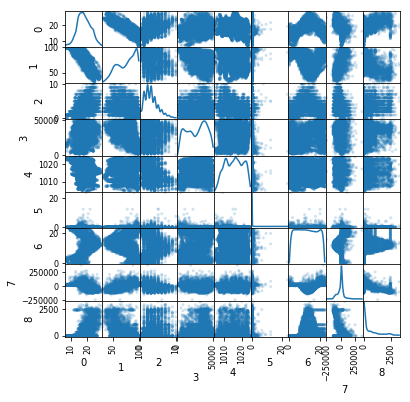

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#Merge energy and solar energy produced into feature array
mergedMatrix = np.c_[featureArray,labels,labels_solar]
#Create a pandas dataframe for viz
scatterMatrix = mergedMatrix[:,2:].astype(float)
df = pd.DataFrame(data = scatterMatrix
                  #columns = ['Temp','humidity',
                  #            'wind speed','visibility',
                  #            'rain','Day Hour',
                  #            'net energy','solar']
                 )

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

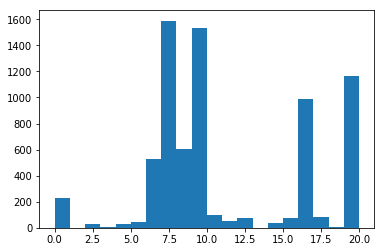

(7174, 13)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f8c928550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5f8a5a6f28>]], dtype=object)

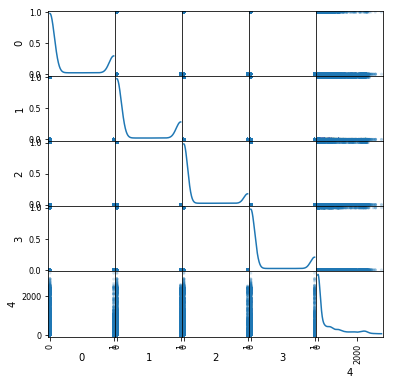

In [10]:
transMatrix = transform_text_labels(featureArray)
merge = np.c_[featureArray,transMatrix]
merge_hot = np.c_[transMatrix,labels_solar]
print(merge.shape)
scatterMatrix = merge_hot.astype(float)
df = pd.DataFrame(data = scatterMatrix)

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')


## Creating a regression model

At this point, we have a clean feature matrix (split into 3 sets) with the corresponding set of labels. Define a helper function to calculate the prediction error for validations and test sets. Define another function that normalizes the feature vector columns. 

Finally use the regression model from scikit-learn to fit training data. Tweak parameters and check their effect by calculating the prediction error for the validation set.

When the best set of parameters are found, check the prediction error on the test-set.

In [11]:
def prediction_error(labels_predict,labels_true):
    """
    Calculates the prediction error as the average absolute difference 
    between predicted and true labels
    
    """
    error = 0
    for predicted,true in zip(labels_predict,labels_true):
        #print('True : {} Predicted : {}'.format(true,predicted))
        error += abs(predicted-true)
    
    error = error/len(labels_predict)
    return error

def normalize_data(data):
    """
    Scales data to [-1,1], to be done before feeding it for regression
    
    """
    scaler = StandardScaler()
    fit = scaler.fit_transform(data)
    return fit

#Split the dataset
data_train,labels_train,data_val,labels_val,data_test,labels_test = split_dataset(featureArray,labels_solar)

# SGD Regression (Don't normalize the one hot encoded labels !)
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
clf = linear_model.SGDRegressor(max_iter = 10**6/X_train.shape[0],
                                tol = 1e-6,
                                alpha = 0.1,
                                )
clf.fit(X_train,labels_train)

print(clf.coef_)
print(clf.score(X_train,labels_train))
print(clf.score(X_val,labels_val))
print(clf.score(X_test,labels_test))



[ 133.03042322 -251.75330956   25.48043631  -44.72709063   41.72478457
   -9.36088965   -5.6717751 ]
0.338264126934
0.216756236624
0.229787659986


In [12]:
# Ridge Regression
ridge = linear_model.Ridge(alpha=10.0)
ridge.fit(X_train,labels_train)
print(ridge.coef_)
print(ridge.score(X_train,labels_train))

print(ridge.score(X_val,labels_val))
print(ridge.score(X_test,labels_test))


[  75.20969338 -353.14012797   13.56201329  -95.68131065   28.47648437
    3.46565242   -3.6926742 ]
0.343598209266
0.211166532537
0.21623982498


In [13]:
# Lasso Regression
lasso = linear_model.Lasso(alpha=10.0)
lasso.fit(X_train,labels_train)
print(lasso.coef_)
print(lasso.score(X_train,labels_train))

print(lasso.score(X_val,labels_val))
print(lasso.score(X_test,labels_test))


[  79.02081786 -327.04508063    2.11989001  -69.968174     15.37647763
    0.           -0.        ]
0.341649489577
0.21515608136
0.223425381637


In [14]:
#Polynomial Features
poly = PolynomialFeatures(degree = 2)
poly_X_train = poly.fit_transform(X_train)
poly_X_val = poly.fit_transform(X_val)
poly_X_test = poly.fit_transform(X_test)

# Lasso Regression
lasso_poly = linear_model.Lasso(alpha=10.0)
lasso_poly.fit(poly_X_train,labels_train)
print(lasso_poly.coef_)
print(lasso_poly.score(poly_X_train,labels_train))

#print(prediction_error(lasso_poly.predict(poly_X_val),labels_val))
#print(prediction_error(lasso_poly.predict(poly_X_test),labels_test))

print(lasso_poly.score(poly_X_val,labels_val))
print(lasso_poly.score(poly_X_test,labels_test))


[  0.00000000e+00   5.18165685e+01  -1.61899254e+02   2.40680958e+01
  -0.00000000e+00   4.60444210e+00   0.00000000e+00  -8.36507260e+00
   1.03346395e+02  -0.00000000e+00   0.00000000e+00  -7.02026553e+01
   0.00000000e+00  -0.00000000e+00  -4.32350072e+01   1.32020369e+02
   0.00000000e+00   0.00000000e+00  -3.42684901e+01   0.00000000e+00
   7.58191224e+01  -2.80134762e+00   0.00000000e+00   2.54472859e+01
   0.00000000e+00   3.67799400e+01  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.24150338e+00  -0.00000000e+00
  -0.00000000e+00   2.54886864e-02  -0.00000000e+00  -1.01720449e+02]
0.446077425723
0.266243138159
0.216023114295


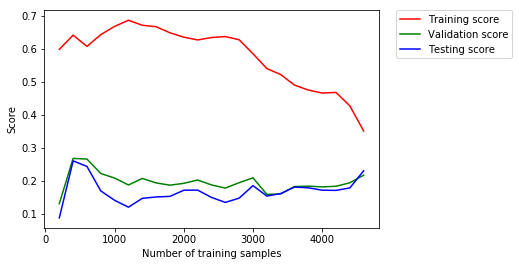

In [15]:
#Plotting test and generalization errors
#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)
num_train_examples = data_train.shape[0]
num_samples = 200
train_error = []
val_error = []
test_error = []
samples = []
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
while num_samples < num_train_examples:
    samples.append(num_samples)
    # Lasso Regression
    lasso = linear_model.Lasso(alpha=10.0)
    lasso.fit(X_train[0:num_samples,:],labels_train[0:num_samples])
    train_error.append(lasso.score(X_train[0:num_samples,:],labels_train[0:num_samples]))
    val_error.append(lasso.score(X_val,labels_val))
    test_error.append(lasso.score(X_test,labels_test))
    num_samples += 200

#Plot the curves
plt.plot(samples,train_error,'r',label='Training score')
plt.plot(samples,val_error,'g',label='Validation score')
plt.plot(samples,test_error,'b',label='Testing score')
plt.ylabel('Score')
plt.xlabel('Number of training samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

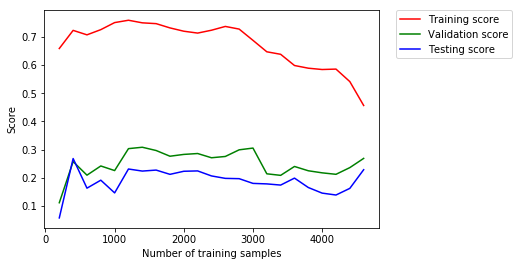

In [16]:
#Plotting test and generalization errors
#Split the dataset
data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels_solar)
num_train_examples = data_train.shape[0]
num_samples = 200
train_error = []
val_error = []
test_error = []
samples = []
X_train = normalize_data(data_train[:,2:].astype(float))
X_val = normalize_data(data_val[:,2:].astype(float))
X_test = normalize_data(data_test[:,2:].astype(float))
poly = PolynomialFeatures(degree = 2)
poly_X_train = poly.fit_transform(X_train)
poly_X_val = poly.fit_transform(X_val)
poly_X_test = poly.fit_transform(X_test)
while num_samples < num_train_examples:
    samples.append(num_samples)
    # Lasso Regression
    lasso = linear_model.Lasso(alpha=10.0)
    lasso.fit(poly_X_train[0:num_samples,:],labels_train[0:num_samples])
    train_error.append(lasso.score(poly_X_train[0:num_samples,:],labels_train[0:num_samples]))
    val_error.append(lasso.score(poly_X_val,labels_val))
    test_error.append(lasso.score(poly_X_test,labels_test))
    num_samples += 200

#Plot the curves
plt.plot(samples,train_error,'r',label='Training score')
plt.plot(samples,val_error,'g',label='Validation score')
plt.plot(samples,test_error,'b',label='Testing score')
plt.ylabel('Score')
plt.xlabel('Number of training samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()